## 可乐碎碎念

Matplotlib是Python中最基本也最重要的可视化工具，可以画出拥有出版质量（Publication-Quality）的图表。如今Matplotlib已经衍生出了很多高层库，但如果需要对图表进行更加精细的个性化设置，就必须深入学习Matplotlib，官网的教程和案例就是最好的学习资源。

但是！我是一个优雅的人，成绩优秀，举止高雅，当然作图也要讲究优雅。接下来我就将着眼于作图的“高效性”、“美观性”和“交互性”，讲一讲**如何优雅地用Matplotlib绘制出一幅优雅的图像，并优雅地插入到LaTex论文文档中。**

在公众号 **“可乐学人”** 后台回复“**Matplotlib**”可以获取本文所有代码和数据，还附赠我的人生箴言一句。

本文预计阅读时间十来分钟吧，希望大家都能有所收获。

In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.use('pdf')
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_excel('data.xls')
data.index = data['Maturity']

df = pd.DataFrame(index=data.index)
for item in ('MC_Price','MC_down','MC_up','DT_Price','TT_Price','WT_Price'):
    df[item] = data[item] - data['MC_Price']

,MC_Price,MC_down,MC_up,DT_Price,TT_Price,WT_Price
Maturity,,,,,,
5,0.0,-0.057453,0.057453,-0.018509,0.007561,0.029403
6,0.0,-0.075561,0.075561,-0.018458,0.015279,0.044810
7,0.0,-0.095543,0.095543,-0.022979,0.021442,0.061872
8,0.0,-0.117444,0.117444,-0.034204,0.024490,0.079387
9,0.0,-0.141266,0.141266,-0.055336,0.021856,0.095461
10,0.0,-0.167180,0.167180,-0.083673,0.016953,0.114231
11,0.0,-0.195472,0.195472,-0.122067,0.007732,0.134187
12,0.0,-0.226559,0.226559,-0.174439,-0.008799,0.153947
13,0.0,-0.260537,0.260537,-0.246867,-0.037654,0.169269


## 高效性：永远永远面向对象

高效的前提是充分理解。这部分首先简单介绍一下Matplotlib的两种接口，在理解Matplotlib逻辑的基础上，实现高效作图就是顺理成章的事了。

### 一、Matplot的两种接口

Matplotlib有两种接口：基于Matlab的和基于面向对象的。基于Matlab的是pyplot提供的，比较简单，但容易混乱；基于面向对象的方法结构清晰，是Matplotlib的精髓。

1. 基于Matlab的：自动创建和管理图和坐标系，用pyplot函数作图；
2. 基于面向对象的：显示创建图和坐标系，再调用对象的方法来作图。

网上好多资料都是把两种接口混合使用的，这对理解Maplotlib的作图逻辑很不友好。Python中，万物皆对象，为了高效作图，我们首先需要做的就是学习使用面向对象的接口。

**Matplotlib的所有对象都叫“Artist”，Artist可以分为两大类别：容器类Containers和基础类Primitives。** 

* 容器类：图(figure)、坐标系(axes)、坐标轴(axis)、刻度(tick)。
* 基础类：线(line)、点(marker)、文字(text)、图例(legend)、网格(grid)、标题(title)。

简单来说，Figure是画布，Axes是画布上一个个区域，所有线、点、文字等基础类元素都是寄生在容器类元素上的。官网也贴心地给出了这些对象的关系，一目了然：

![](https://matplotlib.org/3.2.0/_images/anatomy.png)

使用面向对象接口时，正确的作图流程应该是：
1. 创建figure实例
2. 在figure上创建axes
3. 在axes上添加基础类对象

或者简化为：
1. 创建figure对象和axes对象；
2. 为每个容器类元素添加基础类元素。

再浓缩成指导思想就是：
1. 先找对象；
2. 再解决问题。

### 二、高效作图第一步：创建容器类对象

容器类对象有四类:Figure,Axes,Axis,Tick。这四个是由层级顺序的，一个Figure包含多个Axes，一个Axes包含多个Axis，一个Axis包含多个Tick。

具体而言，Figure就是整个画布，包含了所有坐标系和各种基础类对象；Axes就是我们正常理解中的“图像”，每个Axes都有标题、横轴、纵轴等，Axes是Matplotlib作图逻辑中最最重要的对象；Axis是坐标轴，用来限制图像范围、生成刻度和刻度标签，刻度的位置由Locator对象决定，刻度标签的格式由Formatter控制。

Figure和Axes是作图必备，Axis和tick则是精细调整时才需要考虑的。因此高效作图第一步就是，先把Figure和Axes创建出来。

创建图和坐标系的方法有两种，要么先画图再画坐标系，要么一起画，我个人倾向于一起画，为啥？因为快呗，符合我优雅的人设。
```python
# 优雅地创建图和坐标系
layout = (3, 2) # 坐标系的布局
fig, axes = plt.subplots(*layout) # 添加图和坐标系

# 坐标系索引的两种方式
# 1. 矩阵索引
ax1 = axes[0][0] #第一个坐标系
ax2 = axes[0][1] #第二个坐标系

# 2. 遍历
for ax in axes.flat:
    pass
```

### 三、高效作图第二步：添加基础类对象

基础类对象就是图中所有的点、线、图例、标题这些。需要注意的是，基础类是寄生于容器类的。因此，添加基础类对象时，要先声明容器类对象，也就是说，画画时必须先说清楚在哪里画，这也是基于Matlab的接口和基于面向对象的接口最明显的区别。

各容器类可以添加的基础类总结如下：

```python
# 图
fig.legend() # 图-图例

# 坐标系
ax.plot() # 坐标系-线
ax.scatter() # 坐标系-点
ax.grid() #坐标系-网格
ax.legend() # 坐标系-图例
ax.text() # 坐标系-文字
ax.set_title('Title') # 坐标系-标题

# 坐标轴
ax.set_xlabel('xlabel')  # 坐标系-坐标轴-标签

# 刻度
ax.set_xticklabels(['one', 'two', 'three', 'four', 'five']) # 坐标系-坐标轴-刻度-标签
```
可以看到，大部分对象都是捆绑在Axes上的，这也验证了之前说的，Axes是Matplotlib作图的核心元素。

另外，作为一个优雅的人，如果需要设置很多属性值（property），写一堆`ax.`就太不优雅了，这时候可以使用`ax.set()`来统一设置，简化代码：
```python
# 优雅地添加基础类对象
props = {'title': 'Title', # 坐标系-标题
      'xlabel': 'xlabel', # 坐标系-坐标轴-标签
      'xticklabels':xticklabels_list} # 坐标系-坐标轴-刻度-标签
ax.set(**props)
```

### 四、我是例子

光说不练假把式，接下来用个实例来说明一下。数据就不介绍了，公众号后台回复“Matplotlib”就可以下载。

在导入包和数据后，通过如下一段简单的代码，就可以生成一个五脏俱全的图像：
```python
# 高效作图第一步：创建figure和axes
fig, ax = plt.subplots() # 添加图和坐标系

# 高效作图第二步：添加基础类对象
ax.plot(df.index, df['MC_Price']) # 坐标系-线
ax.plot(df.index, df['DT_Price']) # 坐标系-线
ax.plot(df.index, df['TT_Price']) # 坐标系-线
ax.plot(df.index, df['WT_Price']) # 坐标系-线

props = {'title': 'Title', #坐标系-标题
        'xlabel': 'xlabel', # 坐标系-坐标轴-标签
        'ylabel':'ylabel'} # 坐标系-坐标轴-标签 
ax.set(**props)
```


[Text(0, 0.5, 'ylabel'), Text(0.5, 0, 'xlabel'), Text(0.5, 1.0, 'Title')]

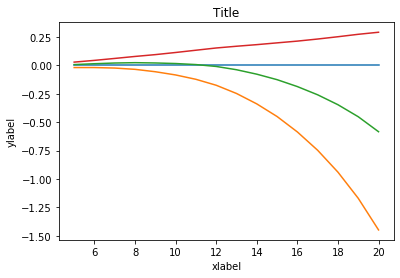

In [2]:
# 添加容器类元素
fig, ax = plt.subplots() # 添加图和坐标系

# 添加基础类元素
ax.plot(df.index, df['MC_Price']) # 坐标系-线
ax.plot(df.index, df['DT_Price']) # 坐标系-线
ax.plot(df.index, df['TT_Price']) # 坐标系-线
ax.plot(df.index, df['WT_Price']) # 坐标系-线

props = {'title': 'Title', #坐标系-标题
        'xlabel': 'xlabel', # 坐标轴-标签
        'ylabel':'ylabel' # 坐标轴-标签
        } 
ax.set(**props)

## 美观性：先全局，后局部

美是很主观的，但也有一些统一的欣赏标准，比如在数据可视化领域十分有影响力的书《The visual display of quantitative information》中，作者提出了最大化 **“data/ink ratio”** 的原则，即，用最少的油墨表示最多的信息。说白了就是大道至简，就是奥卡姆剃刀，说黑了就是AIC准则，就是正则化。

网上的很多教程都是用很繁琐的语句来对图像进行美化，这样写出的代码又臭又长，而且把画图的代码和美化图像的代码混杂到了一起。

其实，几乎所有的配置都可以通过全局参数进行统一声明，因此，先对大局进行统一设置，再在细节上进行微调，这样写出的代码才更加清晰直观，画出的图像也很好看。

### 一、美观作图第一步：全局美化格式

美化格式，无非就是美化元素的属性值，包括字体、字号、子图边距、网格类型等。全局美化有两种方式，一是通过`plt.style.use()`使用官方预定义的样式，二是通过`mpl.rcParams`自定义样式。

官方预定义的样式有很多，用`plt.style.available`可以查看所有可用样式，时间紧迫时可以用这种方法。

我更喜欢用第二种方法，因为可以把自己想要的格式显示地声明出来，每个细节都是自己掌控的。用`mpl.rcParams.keys()`可以查看所有可以全局定义的属性，用`mpl.rcParams.update()`可以实现一行代码更新参数。

我摘录了几个常用的属性，一般情况下设置这些就够了：
```python
params = {
        "font.size": 12,     # 全局字号
        'font.family':'STIXGeneral', # 全局字体
        "figure.subplot.wspace":0.2, # 图-子图-宽度百分比
        "figure.subplot.hspace":0.4, # 图-子图-高度百分比
        "axes.spines.right":False,  # 坐标系-右侧线
        "axes.spines.top":False,   # 坐标系-上侧线
        "axes.titlesize":12,   # 坐标系-标题-字号
        "axes.labelsize": 12,  # 坐标系-标签-字号
        "legend.fontsize": 12,  # 图例-字号
        "xtick.labelsize": 10,  # 刻度-标签-字号
        "ytick.labelsize": 10,  # 刻度-标签-字号
        "xtick.direction":'in',   # 刻度-方向
        "ytick.direction":'in'  # 刻度-方向
}
```

另外，也可以提前对画图时的参数进行预定义。比如我要画四条线，就可以统一定义如下：
```python
style_dict = {
    'MC_Price':dict(linestyle=':', marker='o',markersize=6,color='#fdae61'),
    'WT_Price':dict(linestyle='-',marker='*',markersize=6,color='#d7191c'),
    'DT_Price':dict(linestyle='--',marker='s',markersize=6,color='#abdda4'),
    'TT_Price':dict(linestyle='-.',marker='v',markersize=6,color='#2b83ba')
}
```
这样一来，画图的时候，直接用如下代码就可以方便地完成作图，实现了作图代码和美化代码的分离。
```python
ax.plot(x,y,**style_dict[key])
```
我这里的配色方案是通过http://colorbrewer2.org/ 这个网站生成的，当然，也可以用Matplotlib自带的配色方案或者其他包提供的方案。另外，关于全局参数的设置，高端玩家也可以自己写`matplotlibrc`文件，我就不再展开了，因为我也不会。

### 二、美观作图第二步：局部美化格式

在全局设置好格式以后，就可以肆无忌惮地画图了，而且一般不需要再进行调整，画出的图就可以很好看很好看了。

但有时候在画出图后，仍需对子图间距、坐标轴范围、图例位置、网格透明度等进行局部微调。这部分不需要过分操心，碰到问题随用随查就可以了，或者可以常备一份cheatsheet，也可以快捷地找到解决问题的方法。

有一点需要提醒一下，无论什么时候，都要记住，**先找对象，再解决问题**，这样才可以对画出的图像心中有数。比如下面的几个例子，都要基于fig或者ax，而不是不分红橙黄绿地使用plt。

```python
fig.subplots_adjust(left=0.09, bottom=0.1, right=0.99, top=0.99, wspace=0.1) # 调整子图的位置和间距

ax.set_xlim(min_value, max_value) # 调整坐标轴范围

ax.legend(loc='upper right') #调整图例位置

ax.grid(linestyle="--", alpha=0.2) # 调整网格的线型和透明度
```

### 三、我也是例子

光练一遍假把式，接下来对我们之前做出的图进行美化。通过全局设置部分的代码以及如下局部设置的代码，就可以生成一幅比较优雅的图片了。

```python
# 优雅地创建Figure和Axes
fig, ax = plt.subplots()

# 优雅地添加基础类对象
ax.plot(df.index, df['MC_Price'], **style_dict['MC_Price'])
ax.plot(df.index, df['DT_Price'], **style_dict['DT_Price'])
ax.plot(df.index, df['TT_Price'], **style_dict['TT_Price'])
ax.plot(df.index, df['WT_Price'], **style_dict['WT_Price'])

props = {'xlabel': 'xlabel', # 坐标轴-标签
      'ylabel':'ylabel'}  # 坐标轴-标签
ax.set(**props)

# 优雅地局部美化格式
fig.legend(('MC','DT','TT','WT'),frameon=False, loc='upper center',ncol=4,handlelength=4) # 图例

ax.fill_between(df.index, df['MC_up'], df['MC_down'], alpha=0.15, linewidth=0, color='#fdae61') # 阴影
ax.grid(linestyle="--", alpha=0.2) # 网格线
```


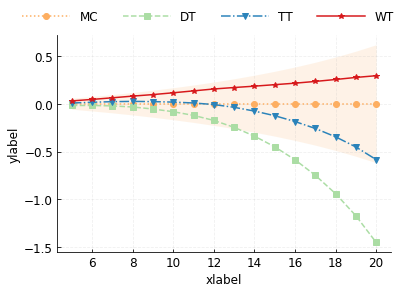

In [3]:
# 全局美化格式
params = {
        "font.size": 12,     # 全局字号
#         'font.family':'STIXGeneral', # 全局字体
        "axes.titlesize":12,   # 坐标系-标题-字号
        "axes.labelsize": 12,  # 坐标系-标签-字号
        "legend.fontsize": 12,  # 图例-字号
        "xtick.labelsize": 12,  # 刻度-标签-字号
        "ytick.labelsize": 12,  # 刻度-标签-字号
        "figure.subplot.wspace":0.2, # 图-子图-宽度百分比
        "figure.subplot.hspace":0.4, # 图-子图-高度百分比
        "axes.spines.right":False,  # 坐标系-右侧线
        "axes.spines.top":False,   # 坐标系-上侧线
        "xtick.direction":'in',   # 刻度-方向
        "ytick.direction":'in'  # 刻度-方向
}

mpl.rcParams.update(params)

style_dict = {
    'MC_Price':dict(linestyle=':', marker='o',markersize=6,color='#fdae61'),
    'WT_Price':dict(linestyle='-',marker='*',markersize=6,color='#d7191c'),
    'DT_Price':dict(linestyle='--',marker='s',markersize=6,color='#abdda4'),
    'TT_Price':dict(linestyle='-.',marker='v',markersize=6,color='#2b83ba')
}

# 局部美化格式
fig, ax = plt.subplots()

ax.plot(df.index, df['MC_Price'], **style_dict['MC_Price'])
ax.plot(df.index, df['DT_Price'], **style_dict['DT_Price'])
ax.plot(df.index, df['TT_Price'], **style_dict['TT_Price'])
ax.plot(df.index, df['WT_Price'], **style_dict['WT_Price'])

props = {
      'xlabel': 'xlabel', # 坐标轴-标签
      'ylabel':'ylabel'}  # 坐标轴-标签
ax.set(**props)

ax.fill_between(df.index, df['MC_up'], df['MC_down'], alpha=0.15, linewidth=0, color='#fdae61') # 阴影
ax.grid(linestyle="--", alpha=0.2) # 网格线

fig.legend(('MC','DT','TT','WT'),frameon=False, loc='upper center',ncol=4,handlelength=4) # 图例

## 交互性：无缝融合LaTex

使用Matplotlib作图有两个目的，要么是要插入到论文里的，要么是其他目的。这部分就介绍一下如何优雅地使用Matplotlib和LaTex来为论文作图。

### 一、交互作图第一步：确定图片的长和宽
为了确保作出的图可以无缝插入到LaTex中，必须避免对Matplotlib生成的图像进行二次缩放，因为已经生成图像后再进行缩放，不仅会缩放长宽，而且字号也会跟着缩放，这是很麻求烦的。

因此，在Matplotlib中作图时就要考虑到最终生成的图的大小，写作时不加修改地直接导入就行了。

先在LaTex文档中插入`\showthe\textwidth`命令来获得最终需要的图片的宽度：

```LaTex
\documentclass{article}
\begin{document}
\showthe\textwidth
\end{document}
```
编译结束后，在`.log`文件中就可以找到这样的字眼：

```LaTex
> 443.86319pt.
l.204     \showthe\textwidth
```
这个443.86319pt就是最终导入时图片的宽度。

但是，还有两个问题没解决：
1. Matplotlib中图片的宽度是用inch做单位的，这里用的是pt；
2. 图片的高度还没确定。

我参考了`Embed-Publication-Matplotlib-Latex`这篇文章给出的解决方案：先进行单位换算，再用黄金比例0.618来确定图片的高度。

核心代码如下，完整代码还需要在公众号后台回复一下，因为有点小长。

```python
fig_width_pt = 443.86319pt
inches_per_pt = 1 / 72.27
golden_ratio = (5**.5 - 1) / 2

fig_width_in = fig_width_pt * inches_per_pt
fig_height_in = fig_width_in * golden_ratio
```

### 交互作图第二步：按格式导出图片

Matplotlib导出的图可以有很多格式，论文作图时，一定要导出矢量图，也就是以`.svg`或者`.pdf`为后缀的，这类图片放大时不会失真。一般而言，SVG格式用于Word，PDF格式用于LaTeX。

还需要注意的是，为了去掉Matplotlib作图时多余的空白部分，导出图片时要传入`bbox_inches='tight'`参数。导出图片的代码如下：

```python
fig.savefig('example.pdf', format='pdf', bbox_inches='tight')
```
将导出的图片保存在LaTex的项目文件夹中，然后只要在LaTex中使用下面的命令，就可以优雅地插入图片了。

```LaTex
\begin{figure}
  \centering
  \includegraphics{example.pdf}
\end{figure}
```

## 总结

Python创建图形的方法非常非常多，大体来说，matplotlib+pandas+seaborn可以用于绘制打印的静态图形，boken+plotly可以用于创建交互式动态图形。

这篇文章只是我个人学习matplotlib的笔记，从高效、美观、交互三方面进行了总结整理，如有错误欢迎批评指正，如对你有帮助，可千万别忘了素质三连呀。

本文的数据和代码在公众号“可乐学人”后台回复“Matplotlib”就可以获得；本文的参考资料包括但不限于：

1. https://matplotlib.org/
2. https://jwalton.info/Embed-Publication-Matplotlib-Latex/
3. https://github.com/jbmouret/matplotlib_for_papers#id24
4. https://github.com/rougier/matplotlib-cheatsheet
5. https://mp.weixin.qq.com/s/QXRXlejzKWox_rvLa66joA

希望大家读完都有收获，我也超爱你们的！